In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd gdrive/My Drive/Samsung\ South\ Korea

/content/gdrive/My Drive/Samsung South Korea


In [3]:
cd Photorealistic-Style-Transfer/

/content/gdrive/My Drive/Samsung South Korea/Photorealistic-Style-Transfer


In [4]:
%cd Photorealistic\ Style\ Transfer

/content/gdrive/My Drive/Samsung South Korea/Photorealistic-Style-Transfer/Photorealistic Style Transfer


In [0]:
# !wget --quiet  https://upload.wikimedia.org/wikipedia/commons/d/d7/Green_Sea_Turtle_grazing_seagrass.jpg
# !wget --quiet   https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg
# !wget --quiet   https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg
# !wget --quiet   https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
# !wget --quiet   https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg
# !wget --quiet   https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg

In [0]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
import time

import torch
import torch.nn
import torch.optim as optim
from torchvision import transforms, models
# import tensorflow as tf

import HRNet
import utils

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('------------------------------------------------------------------')
print(device)
print('------------------------------------------------------------------')

------------------------------------------------------------------
cuda
------------------------------------------------------------------


In [7]:
# get the VGG19's structure except the full-connect layers
VGG = models.vgg19(pretrained=True).features
VGG.to(device)
print(VGG)
# only use VGG19 to extract features, we don't need to change it's parameters
for parameter in VGG.parameters():
    parameter.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth



Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPo

In [0]:
style_net = HRNet.HRNet()
style_net.to(device)
a=3
# print(style_net)

In [0]:
content_image = utils.load_image("./img_dir/Tuebingen_Neckarfront.jpg", img_size=500)  # temporary/content.png
content_image = content_image.to(device)

style_image = utils.load_image("./img_dir/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg")
# style_image = utils.load_image("./../supplementary_material/output_images/flower/style.png")  # temporary/style.png
style_image = style_image.to(device)

In [0]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return torch.sum(torch.abs(x_deltas)) + torch.sum(torch.abs(y_deltas))

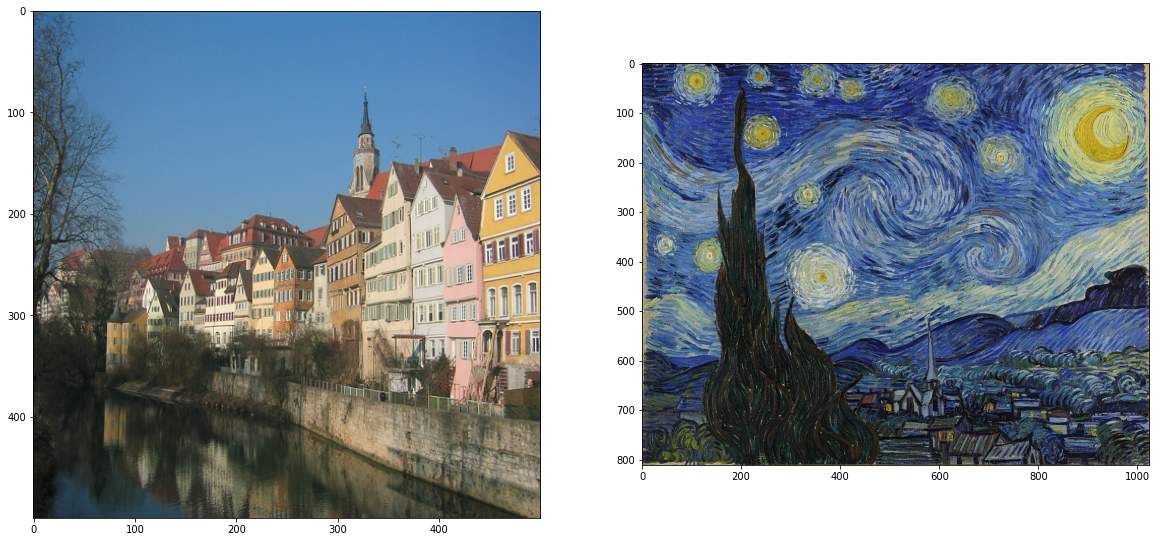

In [18]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(style_image))
plt.show()

In [0]:
content_features = utils.get_features(content_image, VGG)
style_features   = utils.get_features(style_image, VGG)

style_gram_matrixs = {layer: utils.get_grim_matrix(style_features[layer]) for layer in style_features}

target = content_image.clone().requires_grad_(True).to(device)

In [0]:
# try to give fore con_layers more weight so that can get more detail in output iamge
style_weights = {'conv1_1': 0.2,
                 'conv2_1': 0.3,
                 'conv3_1': 0.6,
                 'conv4_1': 1,
                 'conv5_1': 5}
content_weights = {'conv3_2': 0.5,
                   'conv4_2': 1}
#                   #  'conv4_1': 0.5}

# style_weights = {'conv1_1': 0.1,
#                  'conv2_1': 0.2,
#                  'conv3_1': 0.4,
#                  'conv4_1': 0.8,
#                  'conv5_1': 1.6}
# content_weights = {'conv4_2': 1}

content_weight = 1000
style_weight = 1
total_variation_weight=4e-4
show_every = 100
optimizer = optim.Adam(style_net.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.9)
steps = 1000

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []
output_image = content_image

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


After 0 criterions:
Total loss:  14844.220703125
Content loss:  1.0272728204727173
Style loss:  13579.544921875
Total Variation loss:  593509.25


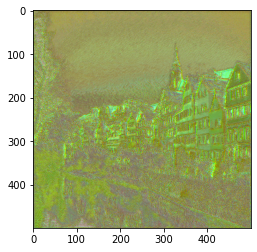

After 100 criterions:
Total loss:  1993.972900390625
Content loss:  0.9597201943397522
Style loss:  609.1577758789062
Total Variation loss:  1062737.375


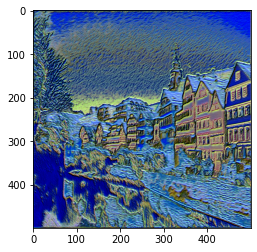

After 200 criterions:
Total loss:  1791.5555419921875
Content loss:  0.8801709413528442
Style loss:  442.2648010253906
Total Variation loss:  1172799.5


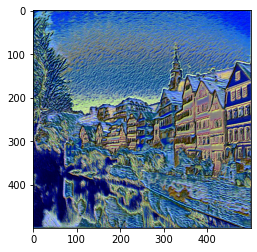

After 300 criterions:
Total loss:  1803.755126953125
Content loss:  0.835390567779541
Style loss:  476.8065490722656
Total Variation loss:  1228894.875


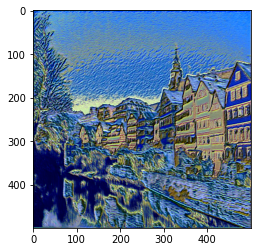

After 400 criterions:
Total loss:  1615.3721923828125
Content loss:  0.734918475151062
Style loss:  364.942626953125
Total Variation loss:  1288777.75


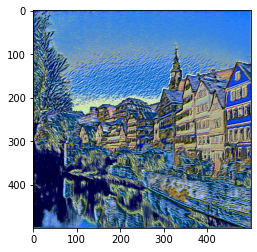

After 500 criterions:
Total loss:  1555.3062744140625
Content loss:  0.6829433441162109
Style loss:  346.1327819824219
Total Variation loss:  1315575.25


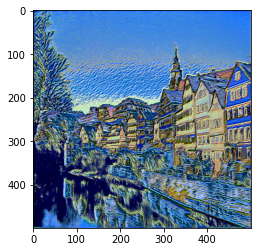

After 600 criterions:
Total loss:  1472.576904296875
Content loss:  0.6242642402648926
Style loss:  310.8952941894531
Total Variation loss:  1343543.5


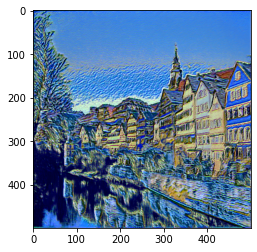

After 700 criterions:
Total loss:  1445.359375
Content loss:  0.598764955997467
Style loss:  297.197265625
Total Variation loss:  1373493.125


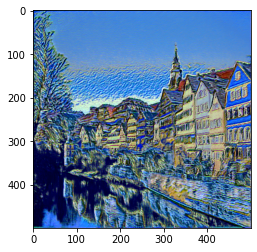

After 800 criterions:
Total loss:  1403.19091796875
Content loss:  0.5669933557510376
Style loss:  275.5775146484375
Total Variation loss:  1401550.25


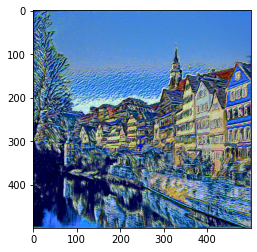

After 900 criterions:
Total loss:  1367.258056640625
Content loss:  0.5381287336349487
Style loss:  258.1655578613281
Total Variation loss:  1427409.25


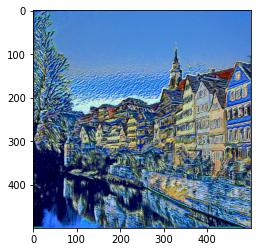

After 1000 criterions:
Total loss:  1353.74951171875
Content loss:  0.5210455656051636
Style loss:  256.7978515625
Total Variation loss:  1439765.0


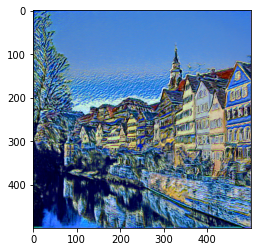

total time  612.307434797287


In [21]:
cosine_loss = torch.nn.CosineEmbeddingLoss().to(device)
time_start=time.time()
for epoch in range(0, steps+1):
    
    # if epoch % 200 == 0:
    #     content_weight *= 0.9
    #     style_weight *= 1.2
    scheduler.step()

    target = style_net(content_image).to(device)
    target.requires_grad_(True)


    target_features = utils.get_features(target, VGG)  # extract output image's all feature maps
    # content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    # compute each layer's content loss and add them

    content_loss = 0
    y = torch.ones(1).to(device)
    for layer in content_weights:
        
        # target_feature = target_features[layer]  # output image's feature map after layer
        
        layer_content_loss = content_weights[layer] * torch.mean(cosine_loss(content_features[layer],  target_features[layer],y))
        
        # layer_content_loss = content_weights[layer] * torch.mean((target_features[layer] - content_features[layer])**2)
        content_loss += layer_content_loss  
    
    style_loss = 0

    # compute each layer's style loss and add them
    for layer in style_weights:
        
        target_feature = target_features[layer]  # output image's feature map after layer
        target_gram_matrix = utils.get_grim_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]

        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c * h * w)
    
    image = target.to("cpu").clone().detach()
    # image = image.numpy()
    
    total_loss = content_weight * content_loss + style_weight * style_loss + total_variation_weight*total_variation_loss((image))
    total_loss_epoch.append(total_loss)

    style_loss_epoch.append(style_weight * style_loss)
    content_loss_epoch.append(content_weight * content_loss)

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % show_every == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        print('Total Variation loss: ', total_variation_loss((image)).item())
        plt.imshow(utils.im_convert(target))
        plt.show()

    output_image = target
time_end=time.time()
print('total time ', time_end - time_start)

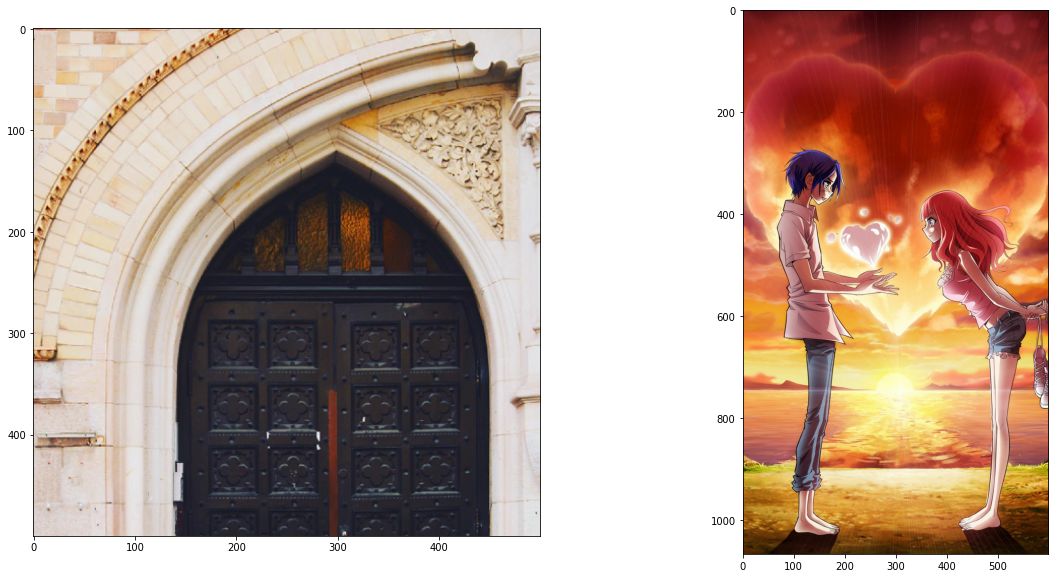

In [0]:
# display the raw images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(utils.im_convert(content_image))
ax2.imshow(utils.im_convert(style_image))
# ax3.imshow(utils.im_convert(target))
plt.show()

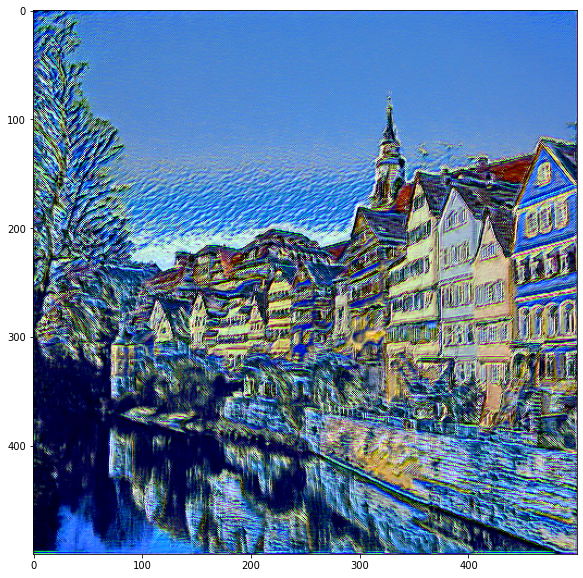

In [22]:
plt.figure(figsize=(20,10))
plt.imshow(utils.im_convert(target))
dir = "l1_loss"
plt.savefig(f"{dir}/Castle-Van-gogh_cosine_total-var_4e-4.png")
plt.show()

tensor(178196.6094)